### Download datasets for this model here:

* https://drive.google.com/drive/folders/19TuTEOKfSOWr4IVf9PrTnN2TQiogoyYV?usp=sharing 

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

 ### Here we deifne how to tansform the the data to fit our models
 
 * With the torchvision transformer function
 * We will randomly flip images horisontally for Data augmentaion with we hope to imporve our accuracy
 * We then transform the dataset into a Tensor.
 * Therafter normalize the data.

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### We also have a transform function for our validation set

In [3]:
valid_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

### We define the training and test sets.

* Here we tell torchvision where the data is, then we load in the data with the DataLoader function
* we also split the data into a training set and a test set by using the train perameters, True or false

In [4]:
dataset = torchvision.datasets.CIFAR10(root='datasets/', download=True, transform=ToTensor())

train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

validation_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                           shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                          shuffle=False, num_workers=4)

validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)

batch_size=128




Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Here we import the Pyplot to assess if the images are loaded correctly or not.

* Importing matplotlip and numpy.
* We define a function to show images from the train_loader dataset
* We create a grid with torchvision and imbed the images into the grid.

In [5]:
len(validation_set), len(test_set), len(train_set)

(10000, 10000, 50000)

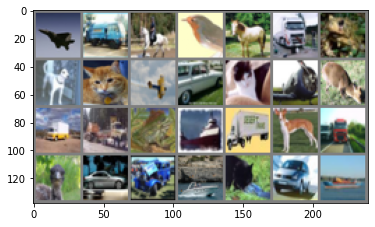

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

### Check how many images the training and testing datasets contain

In [7]:
dataset_size = len(train_set)
test_dataset_size = len(test_set)

print("Training dataset size", dataset_size)
print("Testing datasets size", test_dataset_size)

print(dataset)


Training dataset size 50000
Testing datasets size 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()


### Get the classes of the entire dataset

In [8]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Get the Shapes of the images

In [9]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

### Print a sample image

Label (numeric): 6
Label (textual): frog


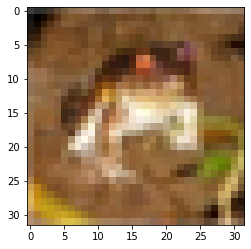

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

### Here we determine the number of images belonging to each class?

* We define the length of the dataset
* We then check hoe many classes there are
* We create a dictionary to store the values
* we then do 2 for loops, first to get the classes and the second to count the amount of images retaining to the classes 

In [11]:
dataset_size = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0
    
for i in range(dataset_size):
    img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


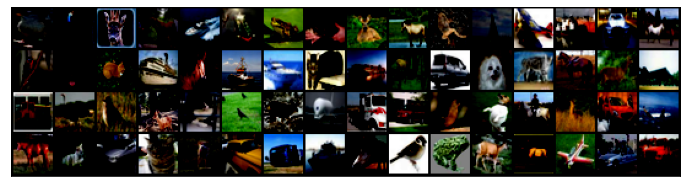

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

### Here we are creating the functionality for calculating the models accuracy

* Todo = Find out how this function works

In [13]:
def accuracyTest(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### ImageClassificationBase contains 4 functions
* One function is for training and validation sets, which implement the loss and accuracy.
* The validation_epoch_end combines the losses and accuracy for each epock 
* The epoch_end prints the val_lass and val_acc at the end of each epoch

In [14]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracyTest(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

##### nn.Sequential chains the layres and activation functions into a single network architecture

In [15]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
print(Cifar10CnnModel)

<class '__main__.Cifar10CnnModel'>


### Here we move our model to GPU if it can run it

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        print("Model will run on, GPU")
        return torch.device('cuda')
    else:
        print("Model will run on, CPU")
        return torch.device('cpu')


In [18]:
device = get_default_device()
device

Model will run on, GPU


device(type='cuda')

#### Here we load the data into the GPU device

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [21]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [22]:
model = to_device(model, device)

### The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

In [23]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, validation_loader)]
history

[{'val_acc': 0.09982085973024368, 'val_loss': 2.3029119968414307}]

### Here we define the input and output size

In [25]:
input_size = 3*32*32
output_size = 10

### Number of epochs to cycle through and the learning rate is set here

In [26]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

### The fit function will record validation loss and metrics for each epoch

In [27]:
history += fit(num_epochs, lr, model, train_loader, validation_loader, opt_func)

Epoch [0], train_loss: 1.6160, val_loss: 1.2515, val_acc: 0.5498
Epoch [1], train_loss: 1.1060, val_loss: 0.9207, val_acc: 0.6803
Epoch [2], train_loss: 0.8458, val_loss: 0.7779, val_acc: 0.7303
Epoch [3], train_loss: 0.7084, val_loss: 0.7223, val_acc: 0.7508
Epoch [4], train_loss: 0.6169, val_loss: 0.6665, val_acc: 0.7731
Epoch [5], train_loss: 0.5507, val_loss: 0.6545, val_acc: 0.7803
Epoch [6], train_loss: 0.4971, val_loss: 0.6090, val_acc: 0.7928
Epoch [7], train_loss: 0.4504, val_loss: 0.6069, val_acc: 0.8042
Epoch [8], train_loss: 0.4102, val_loss: 0.6257, val_acc: 0.7977
Epoch [9], train_loss: 0.3738, val_loss: 0.6183, val_acc: 0.8109


### These functions will plot the losses and accuracy of the history i.e. the training

In [28]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs'); 

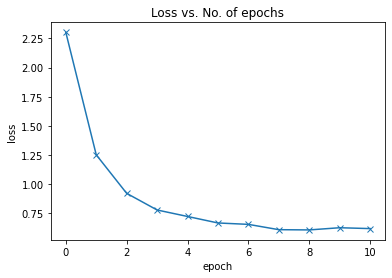

In [29]:
plot_losses(history)

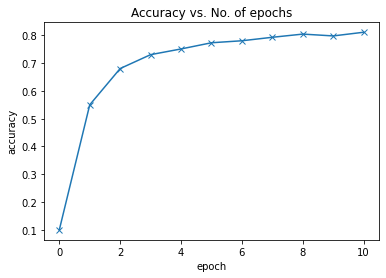

In [30]:
plot_accuracies(history)

### this function will plot will plott the loss difference between the validation set and the training setmm

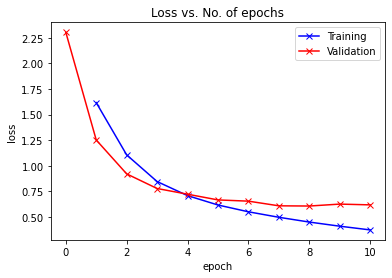

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    
plot_losses(history);

### Get the accuraccy results for each class

In [32]:
type(images)

torch.Tensor

In [33]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label.item())
            y_pred.append(prediction.item())
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 78.3 %
Accuracy for class automobile is: 91.6 %
Accuracy for class bird  is: 71.1 %
Accuracy for class cat   is: 66.9 %
Accuracy for class deer  is: 78.9 %
Accuracy for class dog   is: 79.2 %
Accuracy for class frog  is: 82.7 %
Accuracy for class horse is: 85.4 %
Accuracy for class ship  is: 88.5 %
Accuracy for class truck is: 84.4 %


In [34]:
test_loader = DeviceDataLoader(DataLoader(test_set, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8104492425918579, 'val_loss': 0.6258686184883118}

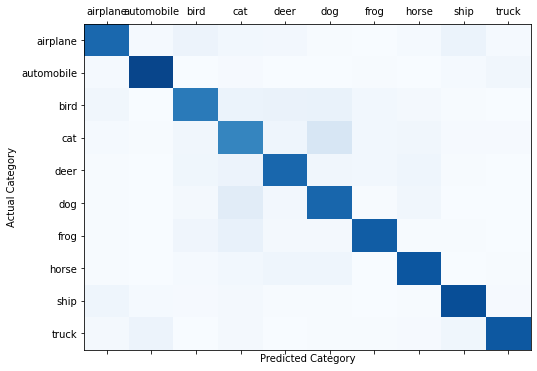

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [36]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        783       12        56        28        25        5         2         13        61        15        
                0.783     0.012     0.056     0.028     0.025     0.005     0.002     0.013     0.061     0.015     
automobile      13        916       2         9         3         3         5         2         15        32        
                0.013     0.916     0.002     0.009     0.003     0.003     0.005     0.002     0.015     0.032     
bird            33        1         711       61        65        68        31        22        6         2         
                0.033     0.001     0.711     0.061     0.065     0.068     0.031     0.022     0.006     0.002     
cat             12        4         32        669       44        160       30        33        8         8         
                0.012     0.004     0.032     0.669     0.044   

In [37]:
TP = 0
FP = 0
FN = 0

for i,r in enumerate(confusion_matrix):
    total = 0
    thisTP = 0
    thisFN = 0
    thisFP = 0 
    for i3 in range (0,10):
        if (i != i3):
            thisFP += confusion_matrix[i3][i]
    for i2,r2 in enumerate(r):
        total += r2
        if (i == i2):
            thisTP += r2
        else:
            thisFN += r2
    
    print(classes[i])
    print('True positives %d' % (thisTP))
    print('False positives %d' % (thisFP))
    print('False negatives %d' % (thisFN))
    precision = thisTP / (thisTP + thisFP)
    recall = thisTP / (thisTP + thisFN)
    print('Precicion {}'.format(precision))
    print('Recall {}'.format(recall))
    f1 = (2 * (precision*recall)) / (precision + recall)
    print('F1 {}'.format(f1))

airplane
True positives 783
False positives 140
False negatives 217
Precicion 0.8483206933911159
Recall 0.783
F1 0.8143525741029641
automobile
True positives 916
False positives 90
False negatives 84
Precicion 0.9105367793240556
Recall 0.916
F1 0.9132602193419741
bird
True positives 711
False positives 214
False negatives 289
Precicion 0.7686486486486487
Recall 0.711
F1 0.7387012987012987
cat
True positives 669
False positives 403
False negatives 331
Precicion 0.6240671641791045
Recall 0.669
F1 0.6457528957528957
deer
True positives 789
False positives 235
False negatives 211
Precicion 0.7705078125
Recall 0.789
F1 0.7796442687747036
dog
True positives 792
False positives 351
False negatives 208
Precicion 0.6929133858267716
Recall 0.792
F1 0.7391507232851144
frog
True positives 827
False positives 114
False negatives 173
Precicion 0.8788522848034006
Recall 0.827
F1 0.8521380731581658
horse
True positives 854
False positives 166
False negatives 146
Precicion 0.8372549019607843
Recall 0.8

In [38]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_actual, y_pred)

0.7857684228622627

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.85      0.78      0.81      1000
  automobile       0.91      0.92      0.91      1000
        bird       0.77      0.71      0.74      1000
         cat       0.62      0.67      0.65      1000
        deer       0.77      0.79      0.78      1000
         dog       0.69      0.79      0.74      1000
        frog       0.88      0.83      0.85      1000
       horse       0.84      0.85      0.85      1000
        ship       0.86      0.89      0.87      1000
       truck       0.92      0.84      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [40]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_actual, y_pred))

0.7855555555555556


In [41]:
##### Loading new datasets

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
### Load images in another way

In [61]:
unseen_set = torchvision.datasets.ImageFolder('/content/drive/MyDrive/AAI_Exam/datasets/NEW_PNGS/', transform=valid_transform)

unseen_loader = torch.utils.data.DataLoader(validation_set, batch_size=64,
                                          shuffle=False, num_workers=4)

batch_size=128

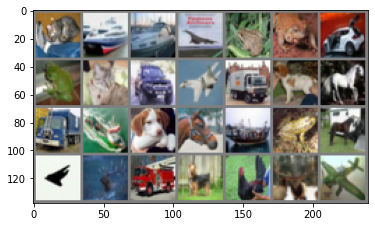

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(unseen_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:28], nrow=7))

In [46]:
classes = unseen_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [47]:
img, label = unseen_set[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

In [48]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: deer , Predicted: dog


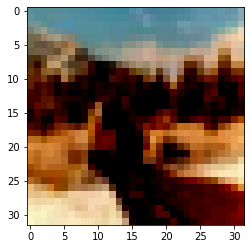

In [49]:
img, label = unseen_set[900]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [63]:
unseen_loader = DeviceDataLoader(unseen_loader, device)
result = evaluate(model, unseen_loader)
result

{'val_acc': 0.8109076619148254, 'val_loss': 0.6182626485824585}

In [64]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
y_actual = []
y_pred = []
confusion_matrix = np.zeros([10,10], int)

# again no gradients needed
with torch.no_grad():
    for data in unseen_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            y_actual.append(label.item())
            y_pred.append(prediction.item())
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predictions[i].item()] += 1 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class airplane is: 79.2 %
Accuracy for class automobile is: 91.6 %
Accuracy for class bird  is: 70.9 %
Accuracy for class cat   is: 69.5 %
Accuracy for class deer  is: 78.8 %
Accuracy for class dog   is: 78.3 %
Accuracy for class frog  is: 83.9 %
Accuracy for class horse is: 85.8 %
Accuracy for class ship  is: 89.2 %
Accuracy for class truck is: 83.4 %


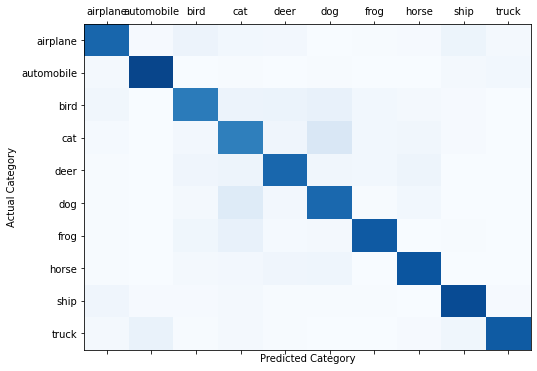

In [66]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

In [67]:
print('actual/pred'.ljust(16), end='')
for i,c in enumerate(classes):
    print(c.ljust(10), end='')
print()
for i,r in enumerate(confusion_matrix):
    print(classes[i].ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()
    r = r/np.sum(r)
    print(''.ljust(16), end='')
    for idx, p in enumerate(r):
        print(str(p).ljust(10), end='')
    print()

actual/pred     airplane  automobilebird      cat       deer      dog       frog      horse     ship      truck     
airplane        792       9         55        30        25        2         6         8         53        20        
                0.792     0.009     0.055     0.03      0.025     0.002     0.006     0.008     0.053     0.02      
automobile      16        916       2         7         3         4         2         3         16        31        
                0.016     0.916     0.002     0.007     0.003     0.004     0.002     0.003     0.016     0.031     
bird            34        3         709       55        62        75        29        21        9         3         
                0.034     0.003     0.709     0.055     0.062     0.075     0.029     0.021     0.009     0.003     
cat             13        3         26        695       41        149       28        34        9         2         
                0.013     0.003     0.026     0.695     0.041   

In [68]:
TP = 0
FP = 0
FN = 0

for i,r in enumerate(confusion_matrix):
    total = 0
    thisTP = 0
    thisFN = 0
    thisFP = 0 
    for i3 in range (0,10):
        if (i != i3):
            thisFP += confusion_matrix[i3][i]
    for i2,r2 in enumerate(r):
        total += r2
        if (i == i2):
            thisTP += r2
        else:
            thisFN += r2
    
    print(classes[i])
    print('True positives %d' % (thisTP))
    print('False positives %d' % (thisFP))
    print('False negatives %d' % (thisFN))
    precision = thisTP / (thisTP + thisFP)
    recall = thisTP / (thisTP + thisFN)
    print('Precicion {}'.format(precision))
    print('Recall {}'.format(recall))
    f1 = (2 * (precision*recall)) / (precision + recall)
    print('F1 {}'.format(f1))

airplane
True positives 792
False positives 139
False negatives 208
Precicion 0.8506981740064447
Recall 0.792
F1 0.8203003625064734
automobile
True positives 916
False positives 98
False negatives 84
Precicion 0.903353057199211
Recall 0.916
F1 0.9096325719960278
bird
True positives 709
False positives 213
False negatives 291
Precicion 0.7689804772234273
Recall 0.709
F1 0.7377731529656608
cat
True positives 695
False positives 400
False negatives 305
Precicion 0.634703196347032
Recall 0.695
F1 0.6634844868735084
deer
True positives 788
False positives 224
False negatives 212
Precicion 0.7786561264822134
Recall 0.788
F1 0.7833001988071571
dog
True positives 783
False positives 341
False negatives 217
Precicion 0.6966192170818505
Recall 0.783
F1 0.7372881355932204
frog
True positives 839
False positives 112
False negatives 161
Precicion 0.882229232386961
Recall 0.839
F1 0.8600717580727832
horse
True positives 858
False positives 161
False negatives 142
Precicion 0.8420019627085378
Recall 

In [69]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_actual, y_pred)

0.7897688131523759

In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.85      0.79      0.82      1000
  automobile       0.90      0.92      0.91      1000
        bird       0.77      0.71      0.74      1000
         cat       0.63      0.69      0.66      1000
        deer       0.78      0.79      0.78      1000
         dog       0.70      0.78      0.74      1000
        frog       0.88      0.84      0.86      1000
       horse       0.84      0.86      0.85      1000
        ship       0.87      0.89      0.88      1000
       truck       0.92      0.83      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [71]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_actual, y_pred))

0.7895555555555555
